# Portfolio Optimization

Let's simulate a bunch of stocks belonging to different industries. Each stock is composed of a deterministic trend $\mu$, a loading on the market related stochastic trend $\beta_{market}$ and a loading on the industry specific stochastic trend $\beta_{industry}$. For each stock, $\mu$, $\beta_{market}$, and $\beta_{industry}$ are sampled from a uniform distribution. In the first simulation, I compare a mean-variance optimization with a naive diversification approach where each asset is equally weighted with the sign of the expected value. At this point I should emphasize that I assume perfect knowledge of the expected value. Traditionally, the expected value is estimated by the in-sample first moment of the asset. In my example, this would actually make sense since the mean is a consistent estimator of the deterministic trend. In practice, however, there is probably not a constant deterministic trend. This is where the alpha model steps in, which is not the topic of this study and thus assumed given. 

The return of each stock is thus given by

$$\begin{aligned} R_{i t} &=\mu_{i}+\beta_{i 1} f_{1 t}+\beta_{i 2} f_{2 t}+\cdots+\beta_{i k} f_{k t}+\epsilon_{i t} \\ &=\mu_{i}+\sum_{\ell=1}^{k} \beta_{i \ell} f_{\ell t}+\epsilon_{i t}, \quad i=1, \ldots, N, \quad t=1, \ldots, T \end{aligned}$$



$\begin{array}{l}{R_{i t} \text { is the return of asset } i \text { at time } t, i=1, \ldots, N} \\ {f_{\ell t} \text { is the } \ell \text { th common factor at time } t, \ell=1, \ldots, k} \\ {\beta_{i \ell} \text { is the factor loading or factor beta of asset } i \text { with respect to factor }} \\ {\ell, i=1, \ldots, N, \ell=1, \ldots, k} \\ {\epsilon_{i t} \text { is the asset-specific factor or asset-specific risk. }}\end{array}$



$\begin{array}{l}{\text { The } k \times k \text { covariance matrix of the factors is }} \\ {\qquad \operatorname{Cov}\left(\boldsymbol{f}_{t}\right)=\boldsymbol{\Sigma}_{f}} \\ {\text { where }} \\ {\qquad \boldsymbol{f}_{t}=\left[f_{1 t}, f_{2 t}, \ldots, f_{k t}\right]^{\prime}}\end{array}$



$\text {Asset-specific noise is uncorrelated with the factors } \operatorname{Cov}\left(f_{\ell t}, \epsilon_{i t}\right)=0, \quad \ell=1, \ldots, k, \quad i=1, \ldots, N, \quad t=1, \ldots, T$,

$\boldsymbol{\Sigma}_{\boldsymbol{\epsilon}}=\operatorname{Cov}\left(\boldsymbol{\epsilon}_{t}\right)=\left[\begin{array}{cccc}{\sigma_{\epsilon_{1}}^{2}} & {0} & {\cdots} & {0} \\ {0} & {\sigma_{\epsilon_{2}}^{2}} & {\cdots} & {0} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {0} & {0} & {\cdots} & {\sigma_{\epsilon_{N}}^{2}}\end{array}\right]=\operatorname{diag}\left(\sigma_{\epsilon_{1}}^{2}, \sigma_{\epsilon_{2}}^{2}, \ldots, \sigma_{\epsilon_{N}}^{2}\right)$,

$\begin{array}{l}{\text { The asset-specific risks are likewise uncorrelated across assets, and for }} \\ {\text { each asset they are serially uncorrelated, }} \\ {\qquad \operatorname{Cov}\left(\epsilon_{i t}, \epsilon_{j t^{\prime}}\right)=\left\{\begin{array}{ll}{\sigma_{i}^{2}} & {\text { if } i=j \text { and } t=t^{\prime}} \\ {0} & {\text { otherwise }}\end{array}\right.}\end{array}$

$\begin{array}{l}{ \text { Thus a diagonal covariance structure reflects the assump- }} \\ {\text { tion that all correlation between assets is due to the factors: }} \\ {\Sigma_{\epsilon}=\operatorname{Cov}\left(\boldsymbol{\epsilon}_{t}\right)=\left[\begin{array}{cccc}{\sigma_{\epsilon_{1}}^{2}} & {0} & {\cdots} & {0} \\ {0} & {\sigma_{\epsilon_{2}}^{2}} & {\cdots} & {0} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {0} & {0} & {\cdots} & {\sigma_{\epsilon_{N}}^{2}}\end{array}\right]=\operatorname{diag}\left(\sigma_{\epsilon_{1}}^{2}, \sigma_{\epsilon_{2}}^{2}, \ldots, \sigma_{\epsilon_{N}}^{2}\right)}\end{array}$

$\begin{array}{l}{\text { If we write the factor model as }} \\ {\qquad \boldsymbol{R}_{t}=\boldsymbol{\alpha}+\boldsymbol{B} \boldsymbol{f}_{t}+\boldsymbol{\epsilon}_{t}, \quad t=1, \ldots, T}\end{array}$

$\begin{array}{l}{\text { where in the } N \times k \text { matrix }} \\ {\qquad B=\left[\begin{array}{c}{\boldsymbol{\beta}_{1}^{\prime}} \\ {\boldsymbol{\beta}_{2}^{\prime}} \\ {\vdots} \\ {\boldsymbol{\beta}_{N}^{\prime}}\end{array}\right]=\left[\begin{array}{cccc}{\beta_{11}} & {\beta_{12}} & {\cdots} & {\beta_{1 k}} \\ {\beta_{21}} & {\beta_{22}} & {\cdots} & {\beta_{2 k}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {\beta_{N 1}} & {\beta_{N 2}} & {\cdots} & {\beta_{N k}}\end{array}\right]} \\ {\text { the }} \ell {\text {th column contains the beta coefficients associated with factor } \ell}\end{array}$

$\begin{array}{l}{\text { The covariance matrix of the returns } R_{t}=\left[R_{1 t}, R_{2 t}, \ldots, R_{N t}\right] \text { implied }} \\ {\text { by the factor model is }} \\ {\qquad \Sigma=\operatorname{Cov}\left(R_{t}\right)=B \Sigma_{f} B^{\prime}+\Sigma_{\epsilon}}\end{array}$

$\begin{array}{l}{\text { That is, }} \\ {\qquad \begin{aligned} \operatorname{Var}\left(R_{i}\right) &=\beta_{i}^{\prime} \Sigma_{f} \beta_{i}+\sigma_{\epsilon_{i}}^{2} \\ \operatorname{Cov}\left(R_{i}, R_{j}\right) &=\beta_{i}^{\prime} \Sigma_{f} \beta_{j} \end{aligned}}\end{array}$

$\begin{array}{l}{\text { Since the factors are uncorrelated in this simulation, the covariance matrix }\text { simplifies to}} \\ {\qquad \Sigma=B \Sigma_{f} B^{\prime}+\Sigma_{\epsilon}=\sum_{\ell=1}^{k} \beta_{\ell} \beta_{\ell}^{\prime} e_{f_{\ell}}^{2}+\Sigma_{\epsilon}}\end{array}$

$\begin{array}{l}{\text { where }} \\ {\beta_{\ell} \text { is the vector of loadings with respect to factor } \ell, \text { i.e. the } \ell \text { th column }} \\ {\text { of matrix } \boldsymbol{B} \text { , }} \\ {\sigma_{f_{\ell}}^{2} \text { is the variance of factor } \ell}\end{array}$

$\text { Thus the variance of asset } i \text { is }$
$$\sigma_{i}^{2}=\sum_{\ell=1}^{k} \beta_{i \ell}^{2} \sigma_{f_{\ell}}^{2}+\sigma_{\epsilon_{i}}^{2} $$

$\text { and the covariance between the returns of assets } i \text { and } j \text { is }$
$$ \sigma_{i j}=\sum_{\ell=1}^{k} \beta_{i \ell} \beta_{j \ell} \sigma_{f_{\ell}}^{2}$$

In [1]:
import numpy as np
import pandas as pd 
from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from matplotlib import pyplot as plt 
plt.style.use('seaborn')
# %matplotlib notebook
from src import optimize
from src.portfolio import Portfolio



def gen_industry_stocks(n_stocks, market, industry, industry_name, sigma_noise, p_year=250):
    mu = pd.Series(np.random.uniform(low=-0.2, high=0.2, size=n_stocks))/p_year
    beta_market = pd.Series(np.random.uniform(low=0.5, high=2.0, size=n_stocks))
    beta_industry = pd.Series(np.random.uniform(low=0.5, high=2.0, size=n_stocks))
    stocks = pd.DataFrame()

    for i in range(n_stocks):
        stocks[f'{industry_name}_stock_{i}'] = (mu[i] +
                                                beta_market[i]*market +
                                                beta_industry[i]*industry +
                                                norm.rvs(size=(1, num_samples))[0]*sigma_noise
                                               )
    mu.index = stocks.columns
    return stocks, mu, beta_market, beta_industry

def information_ratio(equity_curve, p_year=250):
    return equity_curve.mean()/equity_curve.std()*p_year**0.5



p_year = 250
num_samples = p_year*4

sigma_market = 0.1/p_year**0.5
sigma_banks = 0.1/p_year**0.5
sigma_oil = 0.14/p_year**0.5
sigma_insurance = 0.07/p_year**0.5
sigma_tech = 0.2/p_year**0.5
sigma_bio = 0.12/p_year**0.5
sigma_pharma = 0.22/p_year**0.5
sigma_auto = 0.05/p_year**0.5
sigma_retail = 0.125/p_year**0.5
sigma_manufacturing = 0.1/p_year**0.5

sigma_noise = 0.1/p_year**0.5


In [2]:
def plot_equity_curve(log_returns):
    plt.plot(np.exp(log_returns.cumsum()))
    plt.title('Equity Curve')
    plt.xlabel('Period')
    plt.ylabel('Equity Value')
    plt.show()



def show_standard_optimized_equity(n_stocks, industry, long_only=False):
    trainig_pct = 0.5
    n_train = int(trainig_pct*num_samples)
    market = norm.rvs(size=(1, num_samples))[0]*sigma_market
    
    stocks, mu, beta_market, beta_industry = gen_industry_stocks(n_stocks,
                                                                 market,
                                                                 list(industry.values())[0],
                                                                 list(industry.keys())[0],
                                                                 sigma_noise,
                                                                 p_year
                                                                )
    plot_equity_curve(stocks)
    
    if long_only:
        lower_bound = 0
        equal_weights = mu.apply(lambda x: 0 if x<=0 else 1)
        equal_weights = equal_weights/equal_weights.sum()
        market_neutral = False
    else:
        lower_bound = -1
        equal_weights = mu.apply(np.sign)/mu.shape[0]
        market_neutral = True
    
    weights = optimize.minimize_objective(mu.index,
                                     optimize.negative_sharpe,
                                     market_neutral,
                                     (lower_bound, 1),
                                     mu, stocks[:n_train].cov(),
                                     0.0, 0.0,)
    print('|| In-Sample Performance || \n')
    portfolio_sm_is = np.dot(stocks.values,np.array(list(weights.values())))[:n_train]
    IR_ann = information_ratio(portfolio_sm_is)
    print('IR sm_is', IR_ann )
    plot_equity_curve(portfolio_sm_is)
        
    portfolio_equal_is = np.dot(stocks.values, equal_weights)[:n_train]
    IR_ann = information_ratio(portfolio_equal_is)
    print('IR equal_is', IR_ann )
    plot_equity_curve(portfolio_equal_is)

    print('|| Out-of-Sample Performance || \n')
    portfolio_sm_oos = np.dot(stocks.values,np.array(list(weights.values())))[n_train:]
    IR_ann = information_ratio(portfolio_sm_oos)
    print('IR sm_oos', IR_ann )
    plot_equity_curve(portfolio_sm_oos)
    
    portfolio_equal_oos = np.dot(stocks.values, equal_weights)[:n_train]
    IR_ann = information_ratio(portfolio_equal_oos)
    print('IR equal_oos', IR_ann )
    plot_equity_curve(portfolio_equal_oos)
    
    return weights

The results below show that out-of-sample (oos) performance of the optimized portfolio using sample moments (sm) is decent if the number of assets is relatively small. It definently beats equal weighting (equal).

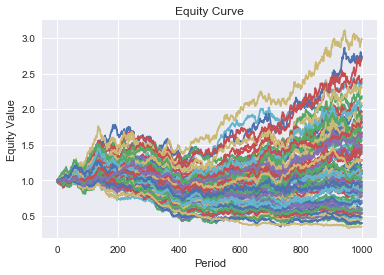

|| In-Sample Performance || 

IR sm_is 12.891231796739163


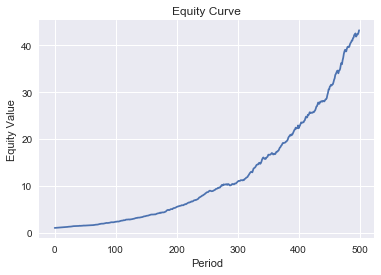

IR equal_is 3.577342393233499


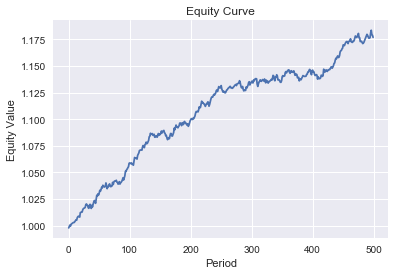

|| Out-of-Sample Performance || 

IR sm_oos 10.152849146805787


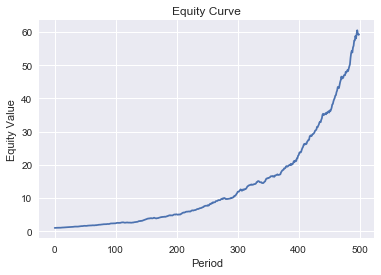

IR equal_oos 3.577342393233499


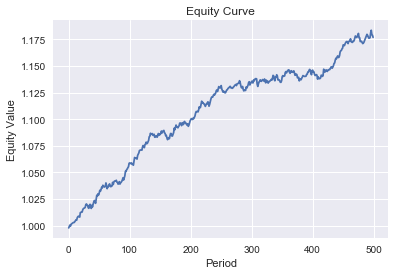

In [3]:
industry = {}
industry['manufacturing'] = norm.rvs(size=(1, num_samples))[0]*sigma_manufacturing
_ = show_standard_optimized_equity(n_stocks=100, industry=industry)

As shown below, long-only performance, of course, is horrendous. This is due to the fact that we cannot diversify the systematic risk. Since we cannot short, hedging out that risk is also not possible. Hence, our bets are not independent and the Law of Large Numbers does not apply.

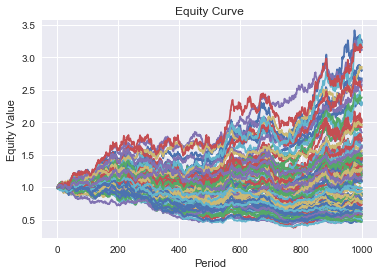

|| In-Sample Performance || 

IR sm_is 1.4752420834779438


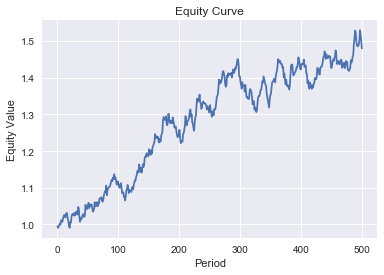

IR equal_is 0.3082941639786964


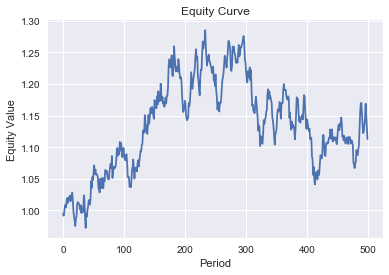

|| Out-of-Sample Performance || 

IR sm_oos 2.2221357144821474


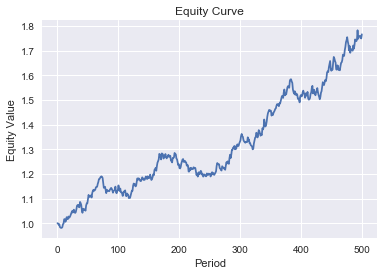

IR equal_oos 0.3082941639786964


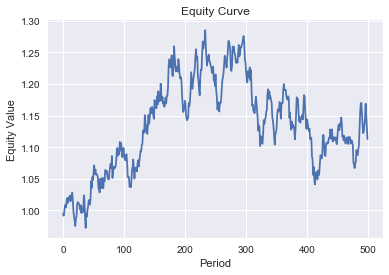

In [4]:
_ = show_standard_optimized_equity(n_stocks=100, industry=industry, long_only=True)

Standard mean-variance optimization works well if the number of assets is relatively small. When the number of assets is relatively large, however, the out-of-sample performance is significantly worse than the in-sample performance as demonstrated by the information ratio (IR). Even the very naive approach of equal weighting beats mean-variance optimization out-of-sample embarrassingly often.

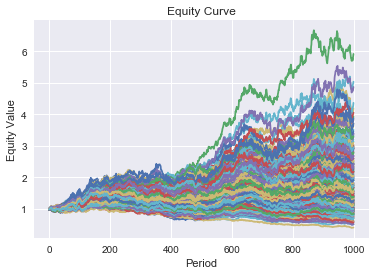

|| In-Sample Performance || 

IR sm_is 27.96396521276888


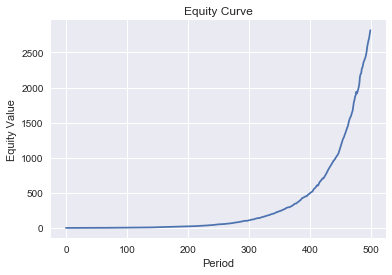

IR equal_is 5.384868430759738


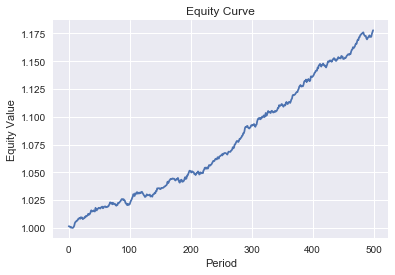

|| Out-of-Sample Performance || 

IR sm_oos 14.492041830349356


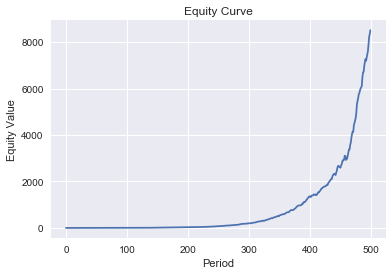

IR equal_oos 5.384868430759738


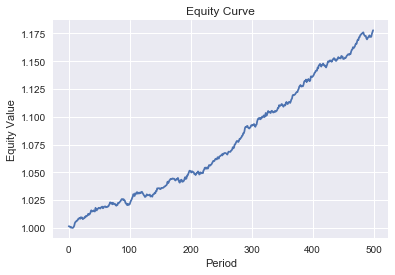

In [5]:
weights = show_standard_optimized_equity(n_stocks=300, industry=industry)

In [6]:
pf = Portfolio(assets=weights.keys(), position=pd.Series(weights), price=[1]*len(weights.keys()))
print(pf)
print('largest long:', pf[0], pf.position(pf[0]))
print('largest short:', pf[-1], pf.position(pf[-1]))

Portfolio: 300 Assets, $22.99 Long, $22.99 Short
largest long: manufacturing_stock_25 0.5538902068174807
largest short: manufacturing_stock_40 -0.5650049440020085


In [7]:
pf.portfolio_df.head()

,position,price,factor_value,sector_id,position_value
manufacturing_stock_25,0.553890,1,1.0,0.0,0.553890
manufacturing_stock_209,0.506290,1,1.0,0.0,0.506290
manufacturing_stock_37,0.466192,1,1.0,0.0,0.466192
manufacturing_stock_167,0.464807,1,1.0,0.0,0.464807
manufacturing_stock_90,0.457723,1,1.0,0.0,0.457723


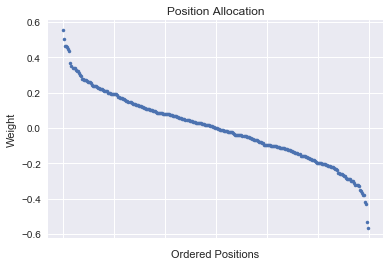

In [8]:
pf.portfolio_df.position_value.plot(style='.')
plt.title('Position Allocation')
plt.xlabel('Ordered Positions')
plt.ylabel('Weight')
plt.show()

Here you can see a typical result of mean-variance optimization. There are some very large positions. These are most likely due to estimation errors of the covariance matrix and thus undesirable. This problem is even greater when $\mu$, too, is estimated with error. As the number of assets grows, there is a higher likelihood of observing an extreme covariance value by chance and thus this problem actually grows with the number of assets. This is so common that it has a name. In the literature it goes by 'Error Maximization'. 


## Imposing Structure

To reduce Error Maximization we need to impose structure. One way to do this is by using our knowledge that stocks usually cluster (e.g., into certain industries). It seems like a good idea to encode this prior knowledge by mean-variance optimize stocks within clusters and then optimize allocation to these clusters. This is pursued next and compared to the standard optimization.

In [9]:
trainig_pct = 0.5
n_train = int(trainig_pct*num_samples)
ir_sm_is = []
ir_sm_oos = []
ir_hier_is = []
ir_hier_oos = []
n_stocks = 50

for j in range(10):
    print('MC run: ', j)
    
    market = norm.rvs(size=(1, num_samples))[0]*sigma_market
    industries = {}
    industries['banks'] =  norm.rvs(size=(1, num_samples))[0]*sigma_banks
    industries['oil'] = norm.rvs(size=(1, num_samples))[0]*sigma_oil
    industries['insurance'] = norm.rvs(size=(1, num_samples))[0]*sigma_insurance
    industries['tech'] = norm.rvs(size=(1, num_samples))[0]*sigma_tech
    industries['bio'] = norm.rvs(size=(1, num_samples))[0]*sigma_bio
    industries['pharma'] = norm.rvs(size=(1, num_samples))[0]*sigma_pharma
    industries['auto'] = norm.rvs(size=(1, num_samples))[0]*sigma_auto
    industries['retail'] = norm.rvs(size=(1, num_samples))[0]*sigma_retail
    
    industries_stocks = {}
    industries_mu = {}
    industries_beta_market = {}
    industries_beta_industries = {}
    industries_weights = {}
    industries_portfolio = {}

    stocks_all = pd.DataFrame()
    expected_returns_all = pd.Series()

    for i in industries.keys():
        industries_stocks[i],\
        industries_mu[i],\
        industries_beta_market[i],\
        industries_beta_industries[i] = gen_industry_stocks(n_stocks,
                                                           market,
                                                           industries[i],
                                                           i,
                                                           sigma_noise,
                                                           p_year
                                                           )
        
        stocks_all = pd.concat([stocks_all,industries_stocks[i]], axis=1)
        expected_returns_all = expected_returns_all.append(industries_mu[i])

        industries_weights[i] = optimize.minimize_objective(industries_mu[i].index,
                                     optimize.negative_sharpe,
                                     True,
                                     (-1, 1),
                                     industries_mu[i], industries_stocks[i][:n_train].cov(),
                                     0.0, 0.0,)
        industries_portfolio[i] = np.dot(industries_stocks[i].values,
                                         np.array(list(industries_weights[i].values())))


    #standard sample moments
    weights = optimize.minimize_objective(expected_returns_all.index,
                                     optimize.negative_sharpe,
                                     True,
                                     (-1, 1),
                                     expected_returns_all, stocks_all[:n_train].cov(),
                                     0.0, 0.0,)
    portfolio_sm_is = np.dot(stocks_all.values,np.array(list(weights.values())))[:n_train]
    IR_ann = information_ratio(portfolio_sm_is)
    ir_sm_is.append(IR_ann)
    print('IR sm_is', IR_ann )

    portfolio_sm_oos = np.dot(stocks_all.values,np.array(list(weights.values())))[n_train:]
    IR_ann = information_ratio(portfolio_sm_oos)
    ir_sm_oos.append(IR_ann)
    print('IR sm_oos', IR_ann )

    # hierarchical
    # optimize allocation to industry
    industry_weights = optimize.minimize_objective(industries.keys(),
                                     optimize.negative_sharpe,
                                     False,
                                     (-1, 1),
                                     pd.Series(index=industries.keys(),
                                               data=[0.1]*len(industries.keys())),
                                     pd.DataFrame(industries_portfolio).cov()[:n_train]*100000,
                                     0.0, 0.0,)
#     # equal weighting industries
#     for i in industry_weights.keys():
#         industry_weights[i] = 1/len(industries)

    print(industry_weights)
    portfolio_hier_is = np.dot(pd.DataFrame(industries_portfolio).values,
                            np.array(list(industry_weights.values())))[:n_train]

    IR_ann = information_ratio(portfolio_hier_is)
    print('IR hier is', IR_ann )
    ir_hier_is.append(IR_ann)

    portfolio_hier_oos = np.dot(pd.DataFrame(industries_portfolio).values,
                            np.array(list(industry_weights.values())))[n_train:]

    IR_ann = information_ratio(portfolio_hier_oos)
    print('IR hier oos', IR_ann )
    ir_hier_oos.append(IR_ann)


MC run:  0
IR sm_is 45.167352199081044
IR sm_oos 9.90220108697107
{'banks': 0.06823824957657224, 'oil': 0.2083392131420988, 'insurance': 0.05819182457050617, 'tech': 0.26211300445886904, 'bio': 0.06006053067348686, 'pharma': 0.1564408936881427, 'auto': 0.010736499453371474, 'retail': 0.17587978443695276}
IR hier is 22.951014409100345
IR hier oos 19.20612781209519
MC run:  1
IR sm_is 48.6753669508914
IR sm_oos 9.862318565636397
{'banks': 0.017596027036522258, 'oil': 0.03682174388372403, 'insurance': 0.03944957960915647, 'tech': 0.4363921084031955, 'bio': 0.06837976614220803, 'pharma': 0.14808072768815214, 'auto': 0.05999486403437562, 'retail': 0.19328518320266608}
IR hier is 19.1859428305399
IR hier oos 17.822484034759903
MC run:  2
IR sm_is 46.58688154357429
IR sm_oos 10.607253780594814
{'banks': 0.09233659384815385, 'oil': 0.19802932240693935, 'insurance': 0.09403976375071554, 'tech': 0.17068817890124346, 'bio': 0.18597403255107375, 'pharma': 0.14779702564284, 'auto': 0.08594146949652

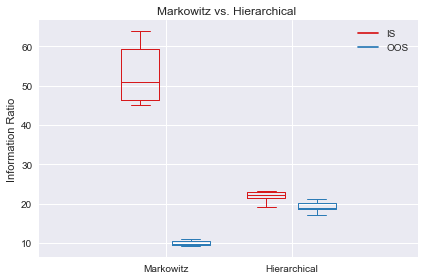

In [10]:
data_a = [ir_sm_is, ir_hier_is]
data_b = [ir_sm_oos, ir_hier_oos]

ticks = ['Markowitz', 'Hierarchical']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)

set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='IS')
plt.plot([], c='#2C7BB6', label='OOS')
plt.legend()
plt.title('Markowitz vs. Hierarchical ')
plt.ylabel('Information Ratio')
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
# plt.ylim(0, 8)
plt.tight_layout()
# plt.savefig('boxcompare.png')

In [11]:
performance_factor = np.mean(ir_hier_oos)/np.mean(ir_sm_oos)
print('OOS performance gain factor', performance_factor)

OOS performance gain factor 1.930546050070575


In [12]:
Portfolio?
dir(Portfolio)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'from_dataframe',
 'gross_exposure',
 'long_exposure',
 'long_exposure_pct',
 'longs',
 'net_exposure',
 'position',
 'sector_net_exposures',
 'short_exposure',
 'short_exposure_pct',
 'shorts',
 'trade']

In [13]:
pf = Portfolio(assets=weights.keys(),
               position=pd.Series(weights),
               price=[1]*len(weights.keys()),
               sector_id=pd.Series(list(weights.keys())).str[:3].values
              )
print(pf)
print('largest long:', pf[0], pf.position(pf[0]))
print('largest short:', pf[-1], pf.position(pf[-1]))
pf.sector_net_exposures()

Portfolio: 400 Assets, $57.1 Long, $57.1 Short
largest long: insurance_stock_34 0.9132788686486976
largest short: auto_stock_1 -0.9987196421399283


,position_value
sector_id,
aut,-0.554285
ban,0.006622
bio,0.531316
ins,0.076345
oil,0.274806
pha,-0.396315
ret,0.904782
tec,-0.843272


In [14]:
pf.portfolio_df.head()

,position,price,factor_value,sector_id,position_value
insurance_stock_34,0.913279,1,1.0,ins,0.913279
bio_stock_17,0.882783,1,1.0,bio,0.882783
pharma_stock_46,0.846411,1,1.0,pha,0.846411
bio_stock_45,0.809910,1,1.0,bio,0.809910
oil_stock_11,0.794617,1,1.0,oil,0.794617


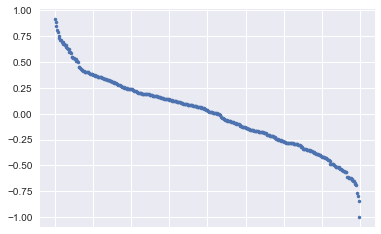

In [15]:
pf.portfolio_df.position_value.plot(style='.')

## Pricipal Component Analysis

Principal Component Analysis (PCA) allows us to reduce the dimension of the covariance matrix. Since the covariance matrix is symmetric we can decompose the matrix into its eigenvalues and eigenvectors. In the simulation we have exposure to the market and several industries. Thus it makes sense to reduce the dimension to the number of these variables. Plotting the proportion of variance explained by the first n principal components confirms this hypothesis.

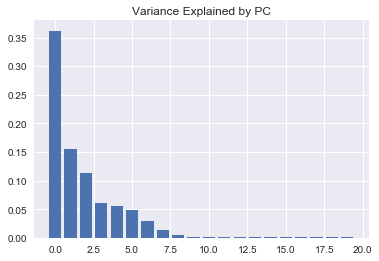

In [16]:
from sklearn.decomposition import PCA as sklearnPCA

n_components = 20
sklearn_pca = sklearnPCA(n_components=n_components) 
pc = sklearn_pca.fit_transform(stocks_all)

plt.bar(range(n_components),sklearn_pca.explained_variance_ratio_)
plt.title('Variance Explained by PC')
plt.show()

In [17]:
cov = stocks_all.cov()
evalues, evectors = np.linalg.eig(cov)
# pr_evalues = np.sort(evalues)[-10:]
n = len(industries)+1
evalues[evalues<evalues[n]] = 0
Q = evectors
R = np.linalg.inv(Q)
L = np.diag(evalues)
pc_cov = pd.DataFrame(Q.dot(L).dot(R))

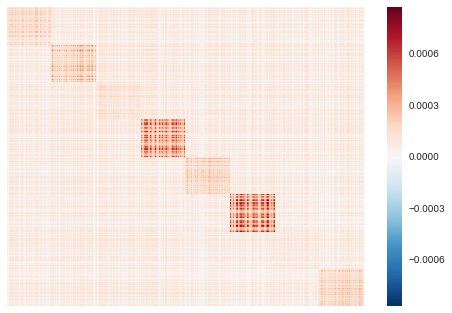

In [18]:
import seaborn as sns
sns.heatmap(pc_cov, xticklabels=False, yticklabels=False)

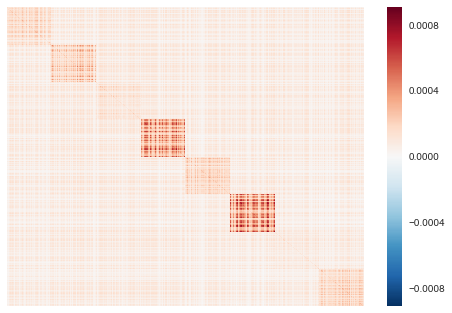

In [19]:
sns.heatmap(cov, xticklabels=False, yticklabels=False)

The heatmaps above look almost indistinguishable after eliminating all other components.


In [20]:
cov = stocks_all[:n_train].cov()

evalues, evectors = np.linalg.eig(cov)
n = len(industries)+1 
evalues[evalues<evalues[n]] = 0
Q = evectors
R = np.linalg.inv(Q)
L = np.diag(evalues)
pc_cov = pd.DataFrame(Q.dot(L).dot(R))


weights = optimize.minimize_objective(expected_returns_all.index,
                                 optimize.negative_sharpe,
                                 True,
                                 (-1, 1),
                                 expected_returns_all, pc_cov,
                                 0.0, 0.0,)

portfolio_pca_is = np.dot(stocks_all.values,
                          np.array(list(weights.values())))[:n_train]
IR_ann = information_ratio(portfolio_pca_is)
print('IR pca_is', IR_ann)

portfolio_pca_oos = np.dot(stocks_all.values,
                           np.array(list(weights.values())))[n_train:]
IR_ann = information_ratio(portfolio_pca_oos)
print('IR pca_oos', IR_ann)

IR pca_is 21.508919858168206
IR pca_oos 23.082867278458046


/Users/jan/Documents/PoCon/src/optimize.py:30: UserWarning: Optimizer did not converge.
  warnings.warn("Optimizer did not converge.")


In [28]:
performance_factor = IR_ann/np.mean(ir_sm_oos)
print('OOS performance gain factor', performance_factor)

OOS performance gain factor 2.3228047325378567


In [29]:
print(np.linalg.matrix_rank(cov))
print(np.linalg.matrix_rank(pc_cov))

400
10


In [22]:
pf = Portfolio(assets=weights.keys(),
               position=pd.Series(weights),
               price=[1]*len(weights.keys()),
               sector_id=pd.Series(list(weights.keys())).str[:3].values
              )
print(pf)
print('largest long:', pf[0], pf.position(pf[0]))
print('largest short:', pf[-1], pf.position(pf[-1]))
pf.sector_net_exposures()

Portfolio: 400 Assets, $108.47 Long, $108.47 Short
largest long: oil_stock_11 0.839842435918997
largest short: retail_stock_44 -0.8452066628222387


,position_value
sector_id,
aut,0.009499
ban,1.210656
bio,0.605714
ins,-1.769501
oil,-1.224902
pha,1.309843
ret,1.950045
tec,-2.091359


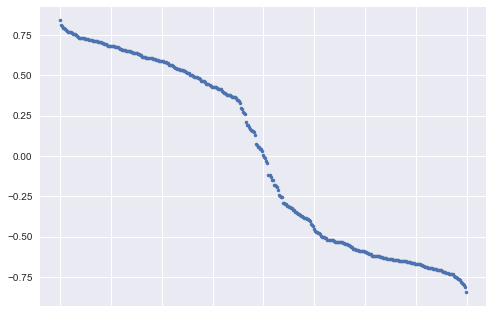

In [23]:
pf.portfolio_df.position_value.plot(style='.')

PCA reduced extreme positions and set a lot fewer weights close to zero.

In [24]:
from scipy.stats import random_correlation

expected_returns = pd.Series([1, 1, -1, -1], index=['a', 'b', 'c', 'd'])
covar = np.array([[ 1.        ,  0.23248961, -0.15653958, -0.00385556],
       [ 0.23248961,  1.        , -0.26070441,  0.10106347],
       [-0.15653958, -0.26070441,  1.        ,  0.36503213],
       [-0.00385556,  0.10106347,  0.36503213,  1.        ]])

In [25]:
weights = optimize.minimize_objective(expected_returns.index,
                                 optimize.negative_sharpe,
                                 True,
                                 (-1, 1),
                                 expected_returns, covar,
                                 0.0, 0.0,)

In [26]:
np.array([[ 1.        ,  0.23248961, -0.15653958, -0.00385556],
       [ 0.23248961,  1.        , -0.26070441,  0.10106347],
       [-0.15653958, -0.26070441,  1.        ,  0.36503213],
       [-0.00385556,  0.10106347,  0.36503213,  1.        ]])

array([[ 1.        ,  0.23248961, -0.15653958, -0.00385556],
       [ 0.23248961,  1.        , -0.26070441,  0.10106347],
       [-0.15653958, -0.26070441,  1.        ,  0.36503213],
       [-0.00385556,  0.10106347,  0.36503213,  1.        ]])

In [27]:
weights

{'a': 0.6633621590810663,
 'b': 0.743466891837888,
 'c': -0.41179637873277863,
 'd': -0.9950326721861757}